In [13]:
import sys
sys.path.insert(0, "../../src")
import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

from utils.utils import get_image_metadata
from models.unets import UnetResnet152
from data.dataset import PredictionDataset

class PredctionDataset(Dataset):
    def __init__(self, dir_path, crop_size=(256,256), transform=None):
        """Prediction dataset for sample images for the Astra Zeneca competition
        
        Group by row_col and field of view
        # row_col
        # field of view
         
        Input and Target share these common values:
        - row_col       = sample id? 
        - field of view = amount of zoom

        For identifying INPUT:
        - action_list_number A04
        - imaging_channel    C04
        - z_number_3d        Z01 - Z07

        For identifying TARGET:
        - action_list_number A01 A02 and A03
        - imaging_channel    C01, C02, C03
        - z_number_3d        Z01
        """
        self.dir_path = dir_path
        
        dataset_samples = glob.glob(os.path.join(self.dir_path, "Assay*"))

        dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
        
        # Group all 7 inputs with all 3 respective targets into variable sample
        samples = dict()
        for sample_dict in dataset_dicts:
            sample_key = (sample_dict["row_col"], sample_dict["field of view"])

            if samples.get(sample_key) is None:
                samples[sample_key] = {
                    "input": dict(),
                    "target": dict(),
                    "mask" : dict()
                }

            if sample_dict["action_list_number"] == "A04":
                # Is an input
                z_number_3d = sample_dict["z_number_3d"]
                samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
            elif sample_dict["is_mask"]:
                # Is a mask
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
            else:
                # Is a target
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["target"][action_list_number] = sample_dict["path"]                

        self.samples = list(samples.values())
        self.crop_size = crop_size
        self.transforms = transform
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Modulo
        idx = idx % len(self.samples)

        sample_dict = self.samples[idx]
        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert self.crop_size[0] <= w
        assert self.crop_size[1] <= h

        input = np.zeros((7, w, h))
        output = np.zeros((3, w, h))
        mask = np.zeros((3, w, h), dtype = 'int16') # As masks will be binary
        input_filenames = list()
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]
            img = cv2.imread(img_path, -1)
            input[i] = img
            input_filenames.append(os.path.basename(img_path))
        
        if self.transforms:
            for transform in self.transforms: 
                input = transform(input)
                
        output_filenames = list()
        for target in ["01", "02", "03"]:
            tf = input_filenames[0]
            target_filename = tf[:43] + 'A' + target + tf[46:49] + 'C' + target + tf[52:]
            #target_filename[43:46] = 'A' + target
            #target_filename[49:52] = 'C' + target
            
            output_filenames.append(target_filename)
        return input, input_filenames, output_filenames
    
dataset = PredctionDataset("../../data/03_training_data/normalized_bias/train/input/20x_images")


In [2]:
inputs, filenames, target_filenames = dataset[0]
print(inputs.shape, filenames, target_filenames)

(7, 2154, 2554) ['AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z01C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z02C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z03C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z04C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z05C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z06C04.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A04Z07C04.tif'] ['AssayPlate_Greiner_#655090_C04_T0001F003L01A01Z01C01.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A02Z01C02.tif', 'AssayPlate_Greiner_#655090_C04_T0001F003L01A03Z01C03.tif']


In [3]:
model = UnetResnet152(input_channels=7, output_channels=1)

In [4]:
x = torch.Tensor(inputs).unsqueeze(0)
print(x.shape)
y=model(torch.zeros(1,7,256,64))
print(y.shape)

torch.Size([1, 7, 2154, 2554])
torch.Size([1, 1, 256, 64])


In [5]:
original_inputs = torch.Tensor(inputs).unsqueeze(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
a2_weights = "../../data/05_saved_models/A2_g_best.pth"
a3_weights = "../../data/05_saved_models/A3_g_best.pth"

In [7]:
weight_file = a2_weights
checkpoint = torch.load(weight_file, map_location=device)
epoch = checkpoint['epoch']
best_valid_loss = checkpoint['best_valid_loss']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
import torchvision.transforms.functional as F2
from functools import wraps
import time

def timeit(my_func):
    @wraps(my_func)
    def timed(*args, **kw):
    
        tstart = time.time()
        output = my_func(*args, **kw)
        tend = time.time()
        
        print('"{}" took {:.3f} ms to execute\n'.format(my_func.__name__, (tend - tstart) * 1000))
        return output
    return timed


In [49]:
import torch.nn.functional as F

@timeit
def strided_predict(original_inputs, model, device, 
                    crop_size:int=256, 
                    stride:int=256, 
                    output_channels:int=1, 
                    batch_size:int=16
                   ):
    assert crop_size >= stride # Crop size must be larger than stride
    
    sizes = np.array([2**i for i in range(10)])
    b, c, w, h = original_inputs.shape
    output_image = torch.zeros(b,output_channels,w,h)
    output_counts = torch.zeros(w,h)

    with torch.no_grad():
        model.eval()
        model.to(device)
        
        batch_tensors = list()
        batch_metadata = list()
        
        for i in range(0, w-crop_size+stride, stride):
            
            for j in range(0, h-crop_size+stride, stride):

                x = original_inputs[:,:,i:i+crop_size,j:j+crop_size]

                # Resize rectangular tensors into allowed rectangular tensors
                crop_shape = x.shape
                
                rectangle_flag = False
                if x.shape[2] != crop_size:
                    rectangle_flag = True
                    idx = np.argmin(np.abs(sizes - x.shape[2]))
                    x = F.interpolate(x, size=(sizes[idx], x.shape[3]))
                if x.shape[3] != crop_size:
                    rectangle_flag = True
                    idx = np.argmin(np.abs(sizes - x.shape[3]))
                    x = F.interpolate(x, size=(x.shape[2], sizes[idx]))
                    
                out = model(x.to(device)).detach().cpu()
                out = F.interpolate(out, size=(crop_shape[2], crop_shape[3]))
                output_counts[i:i+crop_size,j:j+crop_size] += torch.ones(crop_shape[2],crop_shape[3])
                output_image[:,:,i:i+crop_size,j:j+crop_size] += out
                """
                if not rectangle_flag:
                    batch_metadata.append((crop_size, crop_shape, i, j))
                    batch_tensors.append(x)

                    if len(batch_tensors) == batch_size:

                        x_batch = torch.cat(batch_tensors, 0)
                        batch_out = model(x_batch.to(device)).detach().cpu()

                        for out, metadata in zip(batch_out, batch_metadata):
                            out = out.unsqueeze(0)
                            t_crop_size, t_crop_shape, t_i, t_j = metadata

                            #out = F.interpolate(out, size=(crop_shape[2], crop_shape[3]))

                            output_counts[t_i:t_i+t_crop_size,t_j:t_j+t_crop_size] += torch.ones(t_crop_shape[2],t_crop_shape[3])
                            output_image[:,:,t_i:t_i+t_crop_size,t_j:t_j+t_crop_size] += out
                        batch_tensors = list()
                        batch_metadata = list()
                else:
                    # Rectangular boxes are handled for themselves
                    out = model(x.to(device)).detach().cpu()
                    crop_size, crop_shape, i, j = metadata
                    out = F.interpolate(out, size=(crop_shape[2], crop_shape[3]))
                    output_counts[i:i+crop_size,j:j+crop_size] += torch.ones(crop_shape[2],crop_shape[3])
                    output_image[:,:,i:i+crop_size,j:j+crop_size] += out
                    """
                    
    """             
    if len(batch_tensors) != 0:
        x_batch = torch.cat(batch_tensors, 0)
        batch_out = model(x_batch.to(device)).detach().cpu()

        for out, metadata in zip(batch_out, batch_metadata):
            out = out.unsqueeze(0)
            t_crop_size, t_crop_shape, t_i, t_j = metadata
            
            #out = F.interpolate(out, size=(crop_shape[2], crop_shape[3]))

            output_counts[t_i:t_i+t_crop_size,t_j:t_j+t_crop_size] += torch.ones(t_crop_shape[2],t_crop_shape[3])
            output_image[:,:,t_i:t_i+t_crop_size,t_j:t_j+t_crop_size] += out
        batch_tensors = list()
        batch_metadata = list()"""

    output_image = output_image * (1 / output_counts)
    return output_image

output_image = strided_predict(original_inputs, model, device, crop_size=128, stride=128)

#plt.imshow(output_counts)
#plt.imshow(output_image[0,0])

"strided_predict" took 15514.453 ms to execute



In [50]:

@timeit
def test_time_augmentation_predict(inputs, model, device, crop_size=256, stride=256, batched=True):
    """
    # 0 - x
    # 1 - F.hflip(x)
    # 2 - F.vflip(x)
    # 3 - F.hflip(F.vflip(x))
    # 4 - F.rotate(x, 90)
    # 5 - F.rotate(F.hflip(x), 90)
    # 6 - F.rotate(F.vflip(x), 90)
    # 7 - F.rotate(F.hflip(F.vflip(x)), 90)
    """
    # Augment (~1 seconds)
    inputs_0 = inputs
    inputs_1 = F2.hflip(inputs_0)
    inputs_2 = F2.vflip(inputs_0)
    inputs_3 = F2.hflip(inputs_2)
    inputs_4 = F2.rotate(inputs_0, 90, expand=True)
    inputs_5 = F2.hflip(inputs_4)
    inputs_6 = F2.vflip(inputs_4)
    inputs_7 = F2.hflip(inputs_6)
    
    # Inference (~100 seconds GPU)
    if batched:
    
        batched_inputs_0 = torch.cat([inputs_0, inputs_1, inputs_2, inputs_3], 0)
        batched_inputs_1 = torch.cat([inputs_4, inputs_5, inputs_6, inputs_7], 0)
        batched_outputs_0 = strided_predict(batched_inputs_0, model, device, crop_size=crop_size, stride=stride)
        batched_outputs_1 = strided_predict(batched_inputs_1, model, device, crop_size=crop_size, stride=stride)
        outputs_0 = batched_outputs_0[0].unsqueeze(0)
        outputs_1 = batched_outputs_0[1].unsqueeze(0)
        outputs_2 = batched_outputs_0[2].unsqueeze(0)
        outputs_3 = batched_outputs_0[3].unsqueeze(0)
        outputs_4 = batched_outputs_1[0].unsqueeze(0)
        outputs_5 = batched_outputs_1[1].unsqueeze(0)
        outputs_6 = batched_outputs_1[2].unsqueeze(0)
        outputs_7 = batched_outputs_1[3].unsqueeze(0)
                    
    else:
        outputs_0 = strided_predict(inputs_0, model, device, crop_size=crop_size, stride=stride)
        outputs_1 = strided_predict(inputs_1, model, device, crop_size=crop_size, stride=stride)
        outputs_2 = strided_predict(inputs_2, model, device, crop_size=crop_size, stride=stride)
        outputs_3 = strided_predict(inputs_3, model, device, crop_size=crop_size, stride=stride)
        outputs_4 = strided_predict(inputs_4, model, device, crop_size=crop_size, stride=stride)
        outputs_5 = strided_predict(inputs_5, model, device, crop_size=crop_size, stride=stride)
        outputs_6 = strided_predict(inputs_6, model, device, crop_size=crop_size, stride=stride)
        outputs_7 = strided_predict(inputs_7, model, device, crop_size=crop_size, stride=stride)
    
    # Revert augmentation on predictions (~1 seconds)
    outputs_1 = F2.hflip(outputs_1)
    outputs_2 = F2.vflip(outputs_2)
    outputs_3 = F2.vflip(F2.hflip(outputs_3))
    outputs_4 = F2.rotate(outputs_4, -90, expand=True)
    outputs_5 = F2.rotate(F2.hflip(outputs_5), -90, expand=True)
    outputs_6 = F2.rotate(F2.vflip(outputs_6), -90, expand=True)
    outputs_7 = F2.rotate(F2.vflip(F2.hflip(outputs_7)), -90, expand=True)
    
    outputs = outputs_0 + outputs_1 + outputs_2 + outputs_3 + outputs_4 + outputs_5 + outputs_6 + outputs_7
    return outputs / 8


# 92.516947 seconds - 1 inputs
#output_image = test_time_augmentation_predict(original_inputs, model, device)

# 109.032667 seconds - 2 inputs 
# 105.018605 seconds - 3 inputs
#output_image = test_time_augmentation_predict(torch.zeros(3,7,2154,2554), model, device)


In [94]:
input_dir =                "../../data/03_training_data/normalized_bias/train/input/20x_images"
target_dir =               "../../data/03_training_data/normalized_bias/train/targets/20x_images"
dataset = PredctionDataset("../../data/03_training_data/normalized_bias/train/input/20x_images")


inputs, filenames, target_filenames = dataset[0]
x = torch.Tensor(inputs).unsqueeze(0)

# 350.9 seconds - stride = 128
# 47.276119 seconds
# 17 seconds if batched
output_image = test_time_augmentation_predict(x, model, device, crop_size=1024, stride=256)

#output_image = strided_predict(x, model, device, crop_size=256, stride=128)

"strided_predict" took 12137.442 ms to execute

"strided_predict" took 10319.208 ms to execute

"test_time_augmentation_predict" took 24368.671 ms to execute



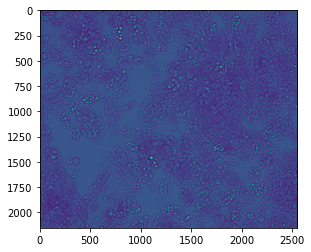

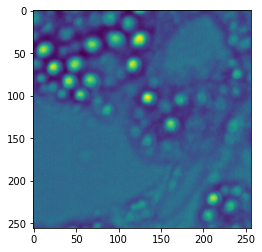

In [95]:
input_path = os.path.join(input_dir, filenames[0])
input_img = cv2.imread(input_path, -1)
plt.imshow(input_img)
plt.show()
plt.imshow(input_img[:256,:256])

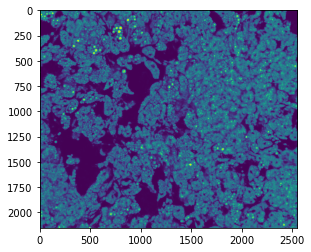

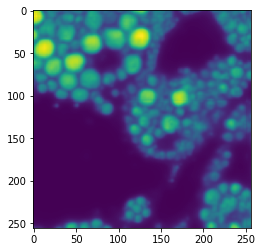

In [96]:
plt.imshow(output_image[0,0])
plt.show()
plt.imshow(output_image[0,0][:256,:256])

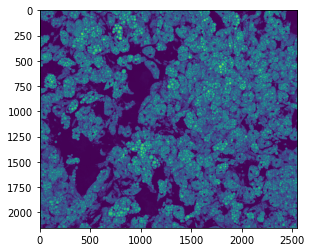

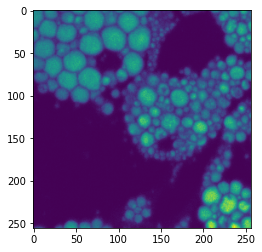

In [97]:
target_path = os.path.join(target_dir, target_filenames[1])
target_img = cv2.imread(target_path, -1)
plt.imshow(target_img)
plt.show()
plt.imshow(target_img[:256,:256])

tensor(234.8512)

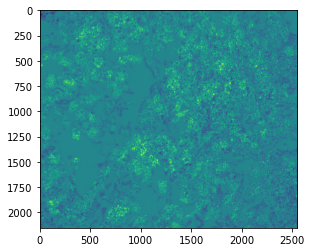

In [98]:
plt.imshow((torch.Tensor(target_img.astype(np.float))-output_image)[0,0])
(torch.Tensor(target_img.astype(np.float))-output_image).abs().mean()

# "Number of TTA" vs "MAE" - Train
# 0 - tensor(262.8758)
# 1 - tensor(260.5205)
# 2 - tensor(256.0114)
# 3 - tensor(250.9733)
# 4 - tensor(248.4582)
# 5 - tensor(247.0434)
# 6 - tensor(246.8050)
# 7 - tensor(246.5606)

# "crop_size" vs "MAE" - Valid, crop_size=1024
# 1024 - tensor(234.8512)
# 2048 - tensor(276.7927)

# "Number of TTA" vs "MAE" - Valid
# 0 - tensor(299.3842)
# 1 - tensor(301.9908)
# 2 - tensor(296.3426)
# 3 - tensor(296.8527)
# 4 - tensor(295.8753)
# 5 - tensor(295.5926)
# 6 - tensor(294.9396)
# 7 - tensor(295.0099) ----- our choice

# "Crop_size" vs "MAE" - Valid, stride=256
# 256  - tensor(295.0099)
# 512  - tensor(291.7748)
# 1024 - tensor(276.7041)
# 2048 - tensor(256.1253) ---- our choice

# "stride" vs "MAE" - Valid, crop_size=2048
# 32   - tensor(276.7927) - 123.0 s
# 64   - tensor(267.9094) -  34.2 s
# 128  - tensor(259.6818) -  11.9 s
# 256  - tensor(254.5930) -   6.1 s -------------
# 1024 - tensor(260.1058) -   5.8 s
# 2048 - tensor(296.1344) -

Text(0, 0.5, 'Mean-absolute error MAE')

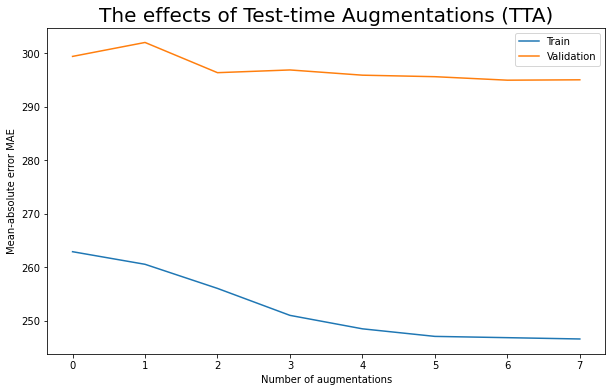

In [64]:
plt.figure(figsize=(10,6))
plt.title("The effects of Test-time Augmentations (TTA)", fontsize=20)
plt.plot([0,1,2,3,4,5,6,7], [262.8758, 260.5205, 256.0114, 250.9733, 248.4582, 247.0434, 246.8050, 246.5606])
plt.plot([0,1,2,3,4,5,6,7], [299.3842, 301.9908, 296.3426, 296.8527, 295.8753, 295.5926, 294.9396, 295.0099])
plt.legend(["Train", "Validation"])
plt.xlabel("Number of augmentations")
plt.ylabel("Mean-absolute error MAE")

In [ ]:

import os
import random
from time import time
from pathlib import Path

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from models.unets import UnetResnet152

if __name__ == "__main__":
    
    cfg = {
        "model_params": {
            "class": "UnetResnet152",
        },
        "save_path": "weights",
        "pred_path": "../../data/05_saved_models/model_1_resnet152_no_normalization.pth",
        "epochs": 400,
        "num_workers": 16,
        "save_checkpoints": True,
        "load_checkpoint": True,#False,

        "train_params": {
            "batch_size": 32,
            "shuffle": True,
        },

        "valid_params": {
            "batch_size": 32,
            "shuffle": False,
        }
        
    }

    Path("output").mkdir(exist_ok=True, parents=True)

    #train_dataset = AstraZenecaDataset("../data/training_dataset/train", transform=training_safe_augmentations)
    #valid_dataset = AstraZenecaDataset("../data/training_dataset/valid", transform=None)
    
    dataset = PredctionDataset("../data/03_training_data/normalized_bias/valid")


    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    model = UnetResnet152(output_channels=1)
        
    # Load checkpoints 
    weight_file = os.path.join(cfg["pred_path"])
    checkpoint = torch.load(weight_file, map_location=device)
    epoch = checkpoint['epoch']
    best_valid_loss = checkpoint['best_valid_loss']
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loading weights: {weight_file}")
    print(f"Trained for {epoch} epochs")
    print(f"Best validation loss {best_valid_loss}")

    
    model.to(device)
    print(f"Starting from epoch {epoch}")
        
    model.eval()        
    torch.set_grad_enabled(False)

    with tqdm(total=len(dataset), desc=f'Epoch {epoch + 1}/{cfg["epochs"]}', unit='img') as pbar:
        for inputs in dataloader:
            inputs = inputs.float()

            inputs = inputs.to(device)
            targets = targets[:,0].unsqueeze(1).to(device)            
            
            preds = model(inputs)

            pbar.set_postfix(**{'valid loss: ': np.mean(valid_losses)})
            pbar.update(inputs.shape[0])

In [ ]:
350899.807 /1000

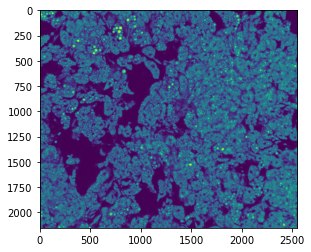

In [108]:
plt.imshow(output_image[0,0].numpy().astype(np.uint16))